In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

library(parallel)

In [3]:
df <- read.table('uncon_v_con_lInsula_shock.txt',header = TRUE,sep = "\t")
print(head(df))
print(dim(df))

                       ROI Subj                          VOX       Y TRAITmean
1 L Anterior dorsal insula  P00 L Anterior dorsal insula 000  0.1975    -1.003
2 L Anterior dorsal insula  P00 L Anterior dorsal insula 001 -0.3554    -1.003
3 L Anterior dorsal insula  P00 L Anterior dorsal insula 002  0.0440    -1.003
4 L Anterior dorsal insula  P00 L Anterior dorsal insula 003  0.2330    -1.003
5 L Anterior dorsal insula  P00 L Anterior dorsal insula 004 -0.0158    -1.003
6 L Anterior dorsal insula  P00 L Anterior dorsal insula 005  0.0333    -1.003
  TRAITdiff STATEmean STATEdiff BPdiff_stdz
1   -0.0406   -1.2307   -0.1812     -0.8664
2   -0.0406   -1.2307   -0.1812     -0.8664
3   -0.0406   -1.2307   -0.1812     -0.8664
4   -0.0406   -1.2307   -0.1812     -0.8664
5   -0.0406   -1.2307   -0.1812     -0.8664
6   -0.0406   -1.2307   -0.1812     -0.8664
[1] 57401     9


In [4]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2


qVars = 'STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
#EOI = 'Intercept,STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOI = 'Intercept'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
print(paste0('Effect of interest: ',EOIq))


dataTable <- df
dataTable$VOX <- factor(dataTable$VOX)
dataTable$ROI <- factor(dataTable$ROI)
# number of ROIs
print(paste0('Number of voxels: ',nlevels(dataTable$VOX)))
print(paste0('Number of ROIs: ',nlevels(dataTable$ROI)))
print(paste0('Number of Subjects: ',nlevels(df$Subj)))
print(paste0('Number of cores available: ', detectCores(all.tests = FALSE, logical = TRUE)))

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Effect of interest: Intercept"
[1] "Number of voxels: 941"
[1] "Number of ROIs: 3"
[1] "Number of Subjects: 61"
[1] "Number of cores available: 16"


,ROI,Subj,VOX,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,L Anterior dorsal insula,P00,L Anterior dorsal insula 000,0.1975,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,L Anterior dorsal insula,P00,L Anterior dorsal insula 001,-0.3554,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,L Anterior dorsal insula,P00,L Anterior dorsal insula 002,0.0440,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,L Anterior dorsal insula,P00,L Anterior dorsal insula 003,0.2330,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,L Anterior dorsal insula,P00,L Anterior dorsal insula 004,-0.0158,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,L Anterior dorsal insula,P00,L Anterior dorsal insula 005,0.0333,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


In [5]:
# Set nuber of cores to use. 
# To run each chain on a single core, set number of core to 4
print(getOption("mc.cores"))
options(mc.cores = parallel::detectCores())
print(getOption("mc.cores"))

NULL
[1] 16


# **1. Bayesian Multi-level modeling**

## **Model 1: Varying intercept and varying slope model.**
ROIs will have varying intercepts and varying slopes for every independent variable.

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{TM}+\beta_{ROI_{TM}})*TM + (\beta_{TD}+\beta_{ROI_{TD}})*TD + (\beta_{SM}+\beta_{ROI_{SM}})*SM + (\beta_{SD}+\beta_{ROI_{SD}})*SD + (\beta_{BPD}+\beta_{ROI_{BPD}})*BPD \epsilon$$

## **Priors**
$$\alpha \sim Student\_t(3,0,10)$$
$$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$$
$$\sigma_{SUB} \sim Student\_t(3,0,10)$$
$$\nu_{SUB} \sim \Gamma(3.325,0.1)$$
$$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$$
$$\sigma_{ROI} \sim Student\_t(3,0,10)$$
$$\nu_{ROI} \sim \Gamma(3.325,0.1)$$
$$\beta_{TM} \sim Student\_t(3,0,10)$$
$$\beta_{TD} \sim Student\_t(3,0,10)$$
$$\beta_{SM} \sim Student\_t(3,0,10)$$
$$\beta_{SD} \sim Student\_t(3,0,10)$$
$$\beta_{BPD} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{BPD}} \sim Student\_t(3,0,10)$$

$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim Student\_t(3,0,10)$$

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [7]:
mod = '1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz'
#mod = '1'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student")) + (',mod,'| gr(ROI, dist="student")) + (',mod,'| gr(VOX, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=dataTable,family = 'student')
priorRBA$prior[10:12] <- "gamma(3.325,0.1)"
priorRBA$prior[14] <- "gamma(3.325,0.1)"
priorRBA$prior[13] <- "student_t(3,0,10)"
priorRBA$prior[15] <- "student_t(3,0,10)"
priorRBA$prior[32] <- "student_t(3,0,10)"
print(modelForm)
priorRBA

[1] "Y ~ 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz + (1 | gr(Subj, dist= \"student\")) + ( 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz | gr(ROI, dist=\"student\")) + ( 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz | gr(VOX, dist=\"student\"))"


,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,,b,BPdiff_stdz,,,,,
3,,b,STATEdiff,,,,,
4,,b,STATEmean,,,,,
5,,b,TRAITdiff,,,,,
6,,b,TRAITmean,,,,,
7,lkj(1),cor,,,,,,
8,,cor,,ROI,,,,
9,,cor,,VOX,,,,


In [ ]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling



In [ ]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

In [12]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

### Functions

In [13]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

################################# conventional GLM ############################################
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

################################# function to plot posteriors ##################################
plotPDP <- function(ps0,gg_brm,gg_glm){
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.25, 0.25)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    #legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **2. BML and GLM Summaries with Posterior Plots**

In [14]:
# for Intercept and quantitative variables
ii = 1
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
#plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for Intercept (RBA results) =====
          mean     SD     P+    2.5%      5%     50%     95%   97.5%
vox000 -0.0399 0.0449 0.1835 -0.1302 -0.1143 -0.0393  0.0332  0.0467
vox001  0.0331 0.0419 0.7882 -0.0489 -0.0357  0.0329  0.1017  0.1152
vox002  0.0643 0.0434 0.9308 -0.0197 -0.0066  0.0639  0.1365  0.1506
vox003  0.0698 0.0412 0.9576 -0.0097  0.0034  0.0694  0.1379  0.1530
vox004 -0.0349 0.0399 0.1890 -0.1141 -0.1013 -0.0344  0.0293  0.0426
vox005 -0.0033 0.0397 0.4762 -0.0817 -0.0689 -0.0024  0.0613  0.0729
vox006 -0.0406 0.0424 0.1684 -0.1249 -0.1110 -0.0405  0.0287  0.0410
vox007 -0.0239 0.0410 0.2793 -0.1044 -0.0918 -0.0237  0.0434  0.0559
vox008 -0.0510 0.0393 0.0966 -0.1291 -0.1157 -0.0510  0.0133  0.0257
vox009 -0.0529 0.0383 0.0806 -0.1282 -0.1158 -0.0528  0.0100  0.0227
vox010  0.0291 0.0415 0.7600 -0.0521 -0.0391  0.0288  0.0974  0.1121
vox011 -0.0383 0.0410 0.1724 -0.1211 -0.1065 -0.0381  0.0284  0.0412
vox012 -0.0367 0.0409 0.1868 -0.1168 

Red vertical lines: GLM

In [16]:
save.image(file="uncon_v_con_lInsula_shock.RData")

# **3. Posterior Predictive Check**

In [20]:
pp_plot = pp_check(fm,nsamples = 100)

Warning message:
“Removed 76252 rows containing non-finite values (stat_density).”
Warning message:
“Removed 905 rows containing non-finite values (stat_density).”


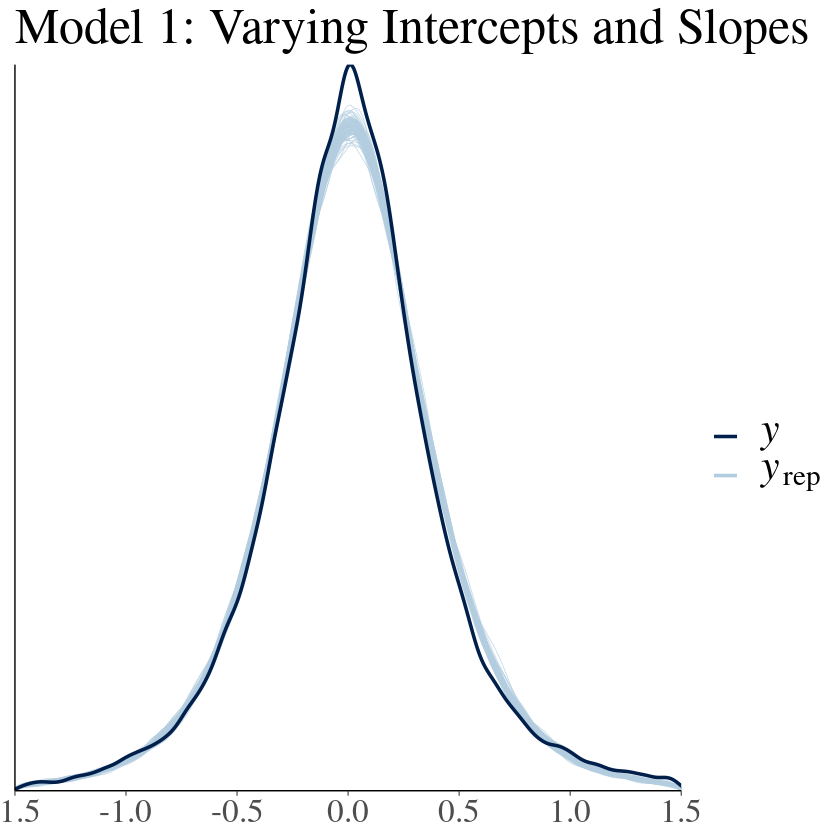

In [21]:
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts and Slopes",)